## Imports & Setup

In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import joblib, time, os
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [25]:
DATA_PATH = "../outputs/endsem"
os.makedirs(DATA_PATH, exist_ok=True)

SEED = 42
np.random.seed(SEED)

# Load & Preprocess (The "Router Buffer")

In [26]:
try:
    data_df_train
except NameError:
    data_df_train = pd.read_parquet(f"{DATA_PATH}/train.parquet")
print(f"Data loaded successfully with shape: {data_df_train.shape}")
try:
    data_df_test
except NameError:
    data_df_test = pd.read_parquet(f"{DATA_PATH}/test.parquet")
print(f"Data loaded successfully with shape: {data_df_test.shape}")

Data loaded successfully with shape: (1770700, 80)
Data loaded successfully with shape: (499426, 80)


In [27]:
X_train_raw = data_df_train.drop(columns=['Label','Attack_Binary']).values
X_test_raw = data_df_test.drop(columns=['Label','Attack_Binary']).values
y_train = data_df_train['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).values
y_test = data_df_test['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).values

# SCALE: Crucial for k-Means and Logistic Regression
# Simulates the router learning the "normal ranges" of traffic
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Save scaler for the "Router Inference" script later
joblib.dump(scaler, f'{DATA_PATH}/router_scaler.joblib')
print("Scaler saved.")

Scaler saved.


# The Coreset Algorithm (Sensitivity Sampling)

## The Coreset's Job: "Don't Delete the Evidence"
The problem with standard "Scaling" (Uniform Random Sampling) is that it blindly deletes data. If an attack type (like DoS Slowloris) appears only 500 times in 2.8 million rows, a 1% random sample might capture 0 of them. You can't learn what isn't there.

- **How Sensitivity Coresets Help**: Because sensitivity is based on "distance from normal," rare attacks have high sensitivity. Even if we shrink the dataset by 95%, the Coreset algorithm is mathematically forced to pick those rare attack packets because they are outliers.

- **Result**: The Coreset ensures the minority class is present in the training buffer.

In [28]:
def generate_coreset(X, y, coreset_ratio=0.05, n_clusters=50):
    """
    Implements Sensitivity Sampling using MiniBatchKMeans.
    Returns: X_core, y_core, sample_weights.
    """

    print(f"--- Generating Coreset (Ratio: {coreset_ratio}) ---")
    t0 = time.time()

    #* 1. Clustering -- The "Structure" of Data
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=SEED, batch_size=4096)
    kmeans.fit(X)

    #* 2. Sensitivity Calculation
    distances = kmeans.transform(X).min(axis=1) #? Distance to Nearest Cluster Center
    sensitivity = distances + 1e-5 #? Adding epsilon to handle duplicates/centers
    probs = sensitivity / sensitivity.sum() #? Normalize for Probability Distribution

    #* 3. Sampling
    coreset_size = int(len(X) * coreset_ratio)
    coreset_indices = np.random.choice(
        np.arange(len(X)),
        size=coreset_size,
        replace=False,
        p=probs
    )

    #* 4. Weighting -- Unbiased Estimation
    weights = 1.0 / (probs[coreset_indices]*len(X)) #? w_i = 1 / (p_i * N)
    weights = weights / weights.mean() #? Normalize Weights to sum to sample size for convergence.

    print(f"Generated {coreset_size} samples in {time.time()-t0:.2f}s")
    return X[coreset_indices], y[coreset_indices], weights

X_core, y_core, w_core = generate_coreset(X_train, y_train)  

--- Generating Coreset (Ratio: 0.05) ---
Generated 88535 samples in 3.89s


# Experiment Loop (The Evidence)

## The Model's Job: "Don't Ignore the Evidence"
Even if the data is present, Logistic Regression might ignore it to maximize overall accuracy. We must force it to care.

- **The Fix**: We add class_weight='balanced' to the Logistic Regression.

    - This tells the model: "Every mistake on a Minority Class example costs 10x more than a mistake on a Majority Class example."

- **Metric Shift**: We stop optimizing for **Accuracy**. We optimize for **Recall** (Detection Rate) and **Maco-F1 Score**.

In [29]:
results = []
ratios = [0.01, 0.05, 0.10]

In [30]:
#* 1. Baseline -- Full Data
print("\n=== Baseline: Full Data Training ===")
t0 = time.time()
model_full = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000, 
    n_jobs=-1,
    class_weight='balanced', #? Handle Class Imbalance
)
model_full.fit(X_train, y_train)
time_full = time.time() - t0
y_pred_full = model_full.predict(X_test)

acc_full = accuracy_score(y_test, y_pred_full)
recall_full = recall_score(y_test, y_pred_full) #! Recall = TP / (TP + FN) -> How many attacks did we catch?
precision_full = precision_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)

results.append({
    'Method': 'Full Dataset',
    'Size': len(X_train),
    'Coreset Ratio': 1.0,
    'Training Time (s)': time_full,
    'Accuracy': acc_full,
    'Recall (Detection Rate)': recall_full,
    'Precision (Positive Predictive Value)': precision_full,
    'F1-Score': f1_full
})
print(f"Full Data Training completed in {time_full:.2f}s with Results:\nAcc={acc_full:.4f}\nRecall={recall_full:.4f}\nPrecision={precision_full:.4f}\nF1={f1_full:.4f}")



=== Baseline: Full Data Training ===
Full Data Training completed in 92.90s with Results:
Acc=0.9394
Recall=0.9757
Precision=0.7446
F1=0.8446


In [31]:
#* 2. Coreset Loop
for ratio in ratios:
    
    #? Generate Coreset
    X_core, y_core, w_core = generate_coreset(X_train, y_train, coreset_ratio=ratio)

    #? Training
    t0 = time.time()
    model_core = LogisticRegression(
        solver='lbfgs', 
        max_iter=1000, 
        n_jobs=-1,
        class_weight='balanced' #? Handle Class Imbalance
    )
    model_core.fit(X_core, y_core, sample_weight=w_core)
    time_core = time.time() - t0

    #? Evaluation
    y_pred_core = model_core.predict(X_test)
    acc_core = accuracy_score(y_test, y_pred_core)
    recall_core = recall_score(y_test, y_pred_core)
    precision_core = precision_score(y_test, y_pred_core)
    f1_core = f1_score(y_test, y_pred_core)
    results.append({
        'Method': 'Coreset',
        'Size': len(X_core),
        'Coreset Ratio': ratio,
        'Training Time (s)': time_core,
        'Accuracy': acc_core,
        'Recall (Detection Rate)': recall_core,
        'Precision (Positive Predictive Value)': precision_core,
        'F1-Score': f1_core
    })

    #? Save the 5%model for "Router Inference" later
    if (ratio == 0.05): 
        joblib.dump(model_core, f'{DATA_PATH}/router_model_coreset_5pct.joblib')
        print("Coreset model (5%) saved.")

--- Generating Coreset (Ratio: 0.01) ---
Generated 17707 samples in 2.73s
--- Generating Coreset (Ratio: 0.05) ---
Generated 88535 samples in 2.57s
Coreset model (5%) saved.
--- Generating Coreset (Ratio: 0.1) ---
Generated 177070 samples in 2.13s


In [32]:
results_df = pd.DataFrame(results)
display(results_df)
results_df.to_csv(f'{DATA_PATH}/ml_phase_results.csv', index=False)
print("\n=== All Results ===")

,Method,Size,Coreset Ratio,Training Time (s),Accuracy,Recall (Detection Rate),Precision (Positive Predictive Value),F1-Score
0,Full Dataset,1770700,1.00,92.902542,0.939400,0.975712,0.744622,0.844646
1,Coreset,17707,0.01,2.746868,0.945533,0.958730,0.773134,0.855987
2,Coreset,88535,0.05,3.780077,0.933696,0.968786,0.728257,0.831476
3,Coreset,177070,0.10,7.682018,0.936235,0.973886,0.734763,0.837592



=== All Results ===


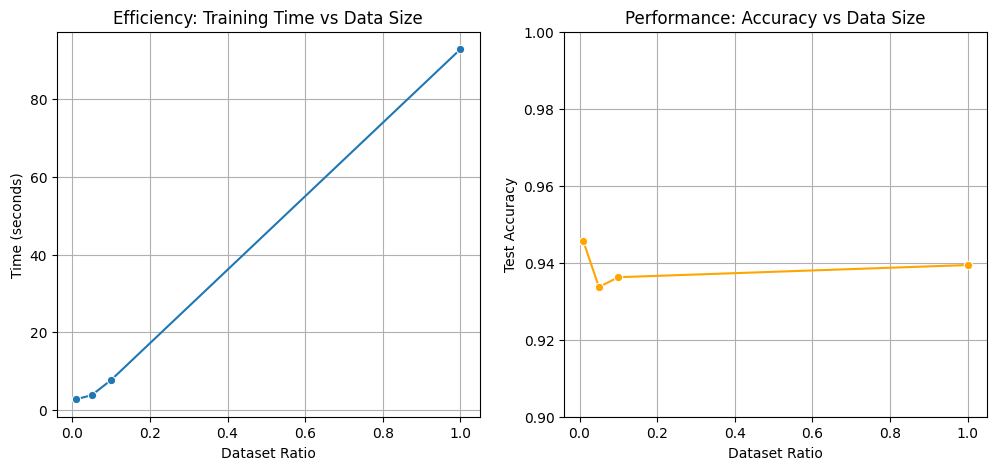

In [ ]:
# Plotting Time vs Accuracy
plt.figure(figsize=(12, 5))

# Plot 1: Training Time Speedup
plt.subplot(1, 2, 1)
# CHANGE x='Ratio' to x='Coreset Ratio'
sns.lineplot(data=results_df, x='Coreset Ratio', y='Training Time (s)', marker='o') 
plt.title('Efficiency: Training Time vs Data Size')
plt.xlabel('Dataset Ratio')
plt.ylabel('Time (seconds)')
plt.grid(True)

# Plot 2: Accuracy Preservation
plt.subplot(1, 2, 2)
# CHANGE x='Ratio' to x='Coreset Ratio'
sns.lineplot(data=results_df, x='Coreset Ratio', y='Accuracy', marker='o', color='orange')
plt.title('Performance: Accuracy vs Data Size')
plt.xlabel('Dataset Ratio')
plt.ylabel('Test Accuracy')
plt.ylim(0.9, 1.0) 
plt.grid(True)

plt.savefig(f'{DATA_PATH}/endsem_comparison_plot.png') # Ensure OUTPUT_DIR is defined, or use '../outputs/'
plt.show()